In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, AveragePooling2D
from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.models import model_from_json
from tensorflow.keras import regularizers
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.models import model_from_json
from itertools import chain


In [ ]:
!pip uninstall tensorflow

In [2]:
import tensorflow as tf

# Print TensorFlow version
print("TensorFlow version:", tf.__version__)

import keras

# Print Keras version
print("Standalone Keras version:", keras.__version__)



TensorFlow version: 2.10.0
Standalone Keras version: 2.10.0


In [2]:
# Adjust alpha and gamma based on class distribution
alpha = [0.3, # anger
         3.1, # contempt
         3.0, # disgust
         1.5, # fear
         0.047, # happiness
         0.048, # neutral
         0.195, # sadness
         0.225 # surprise
        ]

alpha = np.array(alpha)
gamma = 2.15  # Commonly used value, but you can experiment with different values

def categorical_focal_loss(y_true, y_pred, gamma=gamma, alpha=alpha):
    # Clip the predictions to avoid log(0) or log(1)
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

    # Calculate focal loss
    cross_entropy = -y_true * tf.math.log(y_pred)
    loss = alpha * tf.math.pow(1 - y_pred, gamma) * cross_entropy

    # Sum over classes
    return tf.reduce_sum(loss, axis=-1)


In [3]:
TRAIN_DS = r'C:\Users\hunto\projects\onlab\fer_plus\FERPlus\data\resized\FER2013Train_resized'
VALID_DS = r'C:\Users\hunto\projects\onlab\fer_plus\FERPlus\data\resized\FER2013Valid_resized'
TEST_DS = r'C:\Users\hunto\projects\onlab\fer_plus\FERPlus\data\resized\FER2013Test_resized'
TEST_DS2 = r'C:\Users\hunto\projects\onlab\affecnet_lite\dataset_splitted\test'
AUG_DS = r'C:\Users\hunto\projects\onlab\mediapiped\FER2013Train_labeled_mediapiped'
AUG_DS2 = r'C:\Users\hunto\projects\onlab\mediapiped\FER2013Train_labeled_mediapiped_without_happy_neutral'

In [4]:
IMAGE_SIZE = 96
BATCH_SIZE = 64
CLASSES = 8
TRAIN_SIZE = 28558
TEST_SIZE = 3579 
MEDIAPIPE_SIZE = 9571 
TRAIN_SIZE = TRAIN_SIZE #+ MEDIAPIPE_SIZE 

LOSS_FUNCTION = categorical_focal_loss

# Initialize image data generator with rescaling
train_data_gen = ImageDataGenerator(
    rescale=1./255, # 1./255,
    rotation_range=2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

mediapipe_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)

# Preprocess all test images
train_generator = train_data_gen.flow_from_directory(
        TRAIN_DS, 
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        color_mode="rgb",
        class_mode='categorical')


# Preprocess all train images
validation_generator = validation_data_gen.flow_from_directory(
        VALID_DS,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        color_mode="rgb",
        class_mode='categorical')


Found 28558 images belonging to 8 classes.
Found 3579 images belonging to 8 classes.


In [5]:


# Load the AffectNet model structure from the JSON file
with open('emotion_model.json', 'r') as json_file:
    loaded_model_json = json_file.read()

emotion_model = model_from_json(loaded_model_json)

# Load the AffectNet weights into the model
emotion_model.load_weights('emotion_model.h5')



In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Unfreeze some layers of the pre-trained model
for layer in emotion_model.layers:
    layer.trainable = True

# Compile the model again
emotion_model.compile(loss=LOSS_FUNCTION, optimizer=Adam(lr=0.000004), metrics=['accuracy'])   

# Train the model again
emotion_model_info = emotion_model.fit_generator(
    train_generator,
    steps_per_epoch= TRAIN_SIZE // BATCH_SIZE,
    epochs=50,
    validation_data=validation_generator,
    validation_steps= TEST_SIZE  // BATCH_SIZE,
    callbacks=[early_stopping])


C:\Users\hunto\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
C:\Users\hunto\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
446/446 [==============================] - 127s 255ms/step - loss: 0.1919 - accuracy: 0.4489 - val_loss: 0.1473 - val_accuracy: 0.5213
Epoch 2/50
446/446 [==============================] - 108s 242ms/step - loss: 0.1628 - accuracy: 0.5174 - val_loss: 0.1334 - val_accuracy: 0.6071
Epoch 3/50
446/446 [==============================] - 107s 240ms/step - loss: 0.1487 - accuracy: 0.5501 - val_loss: 0.1242 - val_accuracy: 0.6193
Epoch 4/50
446/446 [==============================] - 108s 241ms/step - loss: 0.1407 - accuracy: 0.5617 - val_loss: 0.1237 - val_accuracy: 0.6321
Epoch 5/50
446/446 [==============================] - 109s 243ms/step - loss: 0.1363 - accuracy: 0.5822 - val_loss: 0.1189 - val_accuracy: 0.6395
Epoch 6/50
446/446 [==============================] - 108s 241ms/step - loss: 0.1299 - accuracy: 0.5932 - val_loss: 0.1168 - val_accuracy: 0.5901
Epoch 7/50
446/446 [==============================] - 108s 241ms/step - loss: 0.1256 - accuracy: 0.6051 - val_loss: 0.1138 -

In [9]:
# save model structure in jason file
model_json = emotion_model.to_json()
with open("emotion_model2.json", "w") as json_file:
    json_file.write(model_json)

# save trained model weight in .h5 file
emotion_model.save_weights('emotion_model2.h5')

In [10]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.6.0


In [11]:

# Load the model structure from the JSON file
with open('emotion_model2.json', 'r') as json_file:
    loaded_model_json = json_file.read()

loaded_emotion_model = model_from_json(loaded_model_json)

# Load the weights into the model
loaded_emotion_model.load_weights('emotion_model2.h5')

# Compile the loaded model (if necessary)
loaded_emotion_model.compile(loss=LOSS_FUNCTION, optimizer=Adam(lr=0.001), metrics=['accuracy'])

# Now, loaded_emotion_model is ready for use.
# loaded_emotion_model.summary()

In [12]:
# Load the test dataset
test_data_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_data_gen.flow_from_directory(
    TEST_DS,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False  # Ensure the order of images remains unchanged
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = loaded_emotion_model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Get true labels
true_labels = test_generator.classes

# Predict labels using the model
predicted_labels = loaded_emotion_model.predict(test_generator)

# Convert predictions to class labels
predicted_classes = np.argmax(predicted_labels, axis=1)


Found 3573 images belonging to 8 classes.
56/56 [==============================] - 7s 119ms/step - loss: 0.1158 - accuracy: 0.7008
Test Loss: 0.11579956859350204
Test Accuracy: 0.7008116245269775


In [13]:
predicted_classes[322:352]

array([1, 1, 1, 1, 1, 5, 2, 1, 5, 5, 1, 1, 5, 1, 1, 1, 0, 0, 1, 3, 1, 2,
       1, 1, 1, 5, 1, 6, 1, 0], dtype=int64)

In [14]:
# Load the test dataset
test_data_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_data_gen.flow_from_directory(
    r'C:\Users\hunto\projects\onlab\affecnet_lite\dataset_splitted\test',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False  # Ensure the order of images remains unchanged
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = loaded_emotion_model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Get true labels
true_labels2 = test_generator.classes

# Predict labels using the model
predicted_labels = loaded_emotion_model.predict(test_generator)

# Convert predictions to class labels
predicted_classes2 = np.argmax(predicted_labels, axis=1)

Found 4358 images belonging to 8 classes.
69/69 [==============================] - 6s 80ms/step - loss: 1.2481 - accuracy: 0.5184
Test Loss: 1.2480599880218506
Test Accuracy: 0.5183570384979248


In [16]:
def generate_confusion_matrix(true_labels, predicted_classes):
    # Generate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_classes)
    # Calculate confusion matrix percentages
    conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
    
    # Plot confusion matrix with percentages
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix_percent, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (Percentages)')
    plt.colorbar()
    tick_marks = np.arange(len(validation_generator.class_indices))
    plt.xticks(tick_marks, validation_generator.class_indices, rotation=45)
    plt.yticks(tick_marks, validation_generator.class_indices)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    # Display the percentages on plot
    for i in range(len(validation_generator.class_indices)):
        for j in range(len(validation_generator.class_indices)):
            plt.text(j, i, "{:.2f}%".format(conf_matrix_percent[i, j]),
                     horizontalalignment="center",
                     color="white" if conf_matrix_percent[i, j] > 50 else "black")
    
    plt.tight_layout()
    plt.show()


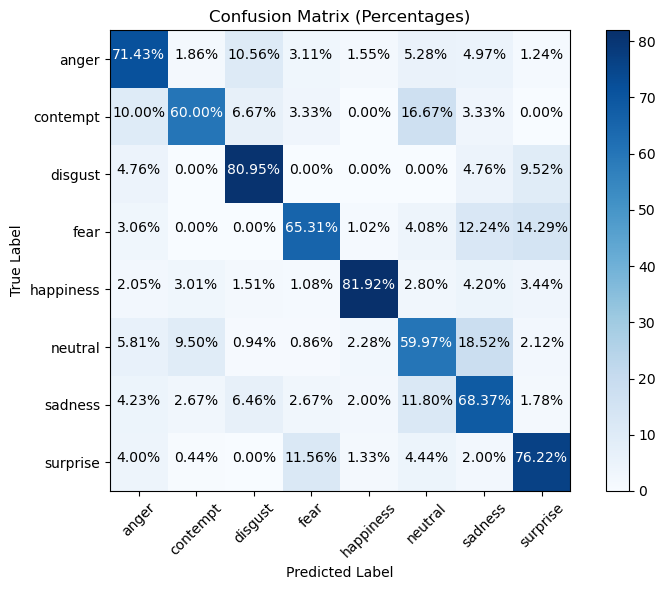

In [17]:
generate_confusion_matrix(true_labels, predicted_classes)

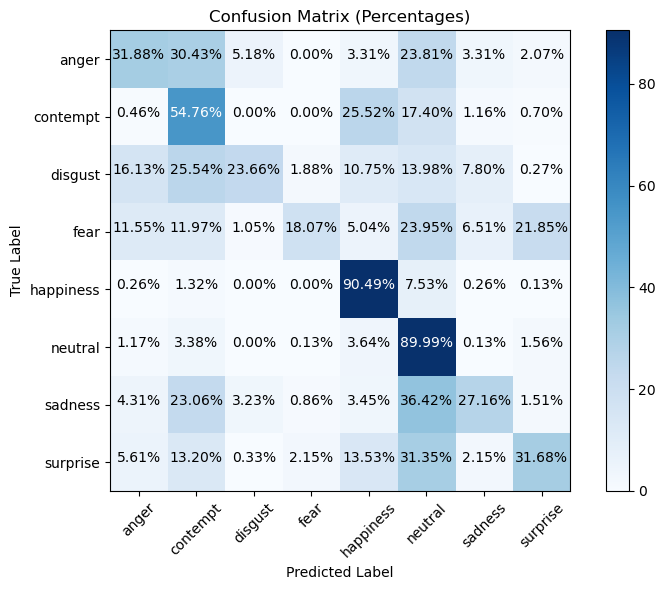

In [18]:
generate_confusion_matrix(true_labels2, predicted_classes2)

In [19]:
test_generator.class_indices

{'anger': 0,
 'contempt': 1,
 'disgust': 2,
 'fear': 3,
 'happy': 4,
 'neutral': 5,
 'sad': 6,
 'suprise': 7}

In [20]:
train_generator.class_indices

{'anger': 0,
 'contempt': 1,
 'disgust': 2,
 'fear': 3,
 'happiness': 4,
 'neutral': 5,
 'sadness': 6,
 'surprise': 7}